### [1] 패키지 불러오기

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import torchvision.transforms as transforms
from PIL import Image

### [2] Data transform 정의

In [2]:
import torchvision.transforms as transforms

# 사이즈 설정
size = [230, 230]
center_size = [224, 224]

# 학습용 Transform
TrainTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 검증/테스트용 Transform
ValidTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### [3] 수정된 Eye dataset 클래스 (thickness 추가)

In [6]:
import json
from PIL import Image
import torch
from torch.utils.data import Dataset

class SingleModalEyeDataset(Dataset):
    def __init__(self, data, image_path, transform=None):
        self.data = data
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        left_img = Image.open(os.path.join(self.image_path, item['left_eye'])).convert('RGB')
        right_img = Image.open(os.path.join(self.image_path, item['right_eye'])).convert('RGB')

        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        label = torch.tensor(item['label'], dtype=torch.long)
        thickness = torch.tensor(item['thickness'], dtype=torch.float32)  # thickness 추가

        return left_img, right_img, label, thickness

    @classmethod
    def from_json(cls, json_file, image_path, group_value=1, include_0_9mm=True, transform=None):
        with open(json_file, 'r') as f:
            raw_data = json.load(f)

        usable_data = [
            item for item in raw_data.values()
            if item['group'] == group_value and (include_0_9mm or item['thickness'] != 0.9)
        ]

        print(f"usable samples for group {group_value}: {len(usable_data)}")
        return cls(usable_data, image_path, transform)


### [4] 구글 드라이브 연동

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### [5] train_loader, val_loader, test_loader 구성

In [7]:
from torch.utils.data import DataLoader

# 경로 설정
json_path = '/content/drive/MyDrive/cv_project/dataset/data_info.json'
image_path = '/content/drive/MyDrive/cv_project/dataset/train_images/Fundus_CIMT_2903 Dataset'

# 데이터셋 생성
train_dataset = SingleModalEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=1, transform=TrainTransform)
val_dataset = SingleModalEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=2, transform=ValidTransform)
test_dataset = SingleModalEyeDataset.from_json(json_file=json_path, image_path=image_path, group_value=3, transform=ValidTransform)

# 최적화된 데이터로더
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


usable samples for group 1: 2603
usable samples for group 2: 200
usable samples for group 3: 100


### [6] SiameseSeResNeXtdropout 모델 정의

In [8]:
import torch.nn as nn
import timm
import torch

class SiameseEfficientNetV2MultiTask(nn.Module):
    def __init__(self, dropout_p=0.3):
        super(SiameseEfficientNetV2MultiTask, self).__init__()
        self.backbone = timm.create_model('tf_efficientnetv2_s.in1k', pretrained=True, num_classes=0)
        self.dropout = nn.Dropout(dropout_p)

        # EfficientNetV2 output feature size = 1280
        # 분류 헤드
        self.classifier = nn.Sequential(
            nn.Linear(1280 * 2, 512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 2)
        )

        # 회귀 헤드
        self.regressor = nn.Sequential(
            nn.Linear(1280 * 2, 512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 1)
        )

    def forward(self, left, right):
        left_feat = self.backbone(left)
        right_feat = self.backbone(right)
        combined_feat = torch.cat([left_feat, right_feat], dim=1)
        combined_feat = self.dropout(combined_feat)

        class_out = self.classifier(combined_feat)
        thickness_out = self.regressor(combined_feat)
        return class_out, thickness_out


### [7] FocalLoss 클래스 정의

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # scalar or list (optional)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')  # [B]
        pt = torch.exp(-ce_loss)  # [B]
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss  # [B]

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


### [8] 학습 루프

In [10]:
import torch.nn.functional as F
from torch import nn
import json

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 손실 함수 정의
criterion_cls = FocalLoss()
criterion_reg = nn.MSELoss()
lambda_reg = 5.0  # 회귀 손실의 가중치

# 모델 초기화
model = SiameseEfficientNetV2MultiTask().to(device)

# 옵티마이저 (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 학습률 스케줄러
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# 에폭 및 손실 초기화
epochs = 20
best_val_loss = float('inf')

# 손실 기록 리스트
train_cls_losses = []
train_reg_losses = []
train_total_losses = []
val_cls_losses = []
val_reg_losses = []
val_total_losses = []

# 학습 루프
for epoch in range(epochs):
    model.train()
    running_cls_loss = 0.0
    running_reg_loss = 0.0
    running_total_loss = 0.0

    for left, right, labels, thicknesses in train_loader:
        left, right = left.to(device), right.to(device)
        labels = labels.to(device)
        thicknesses = thicknesses.to(device)

        optimizer.zero_grad()
        outputs_cls, outputs_reg = model(left, right)

        loss_cls = criterion_cls(outputs_cls, labels)
        loss_reg = criterion_reg(outputs_reg.squeeze(), thicknesses)
        loss = loss_cls + lambda_reg * loss_reg

        loss.backward()
        optimizer.step()

        running_cls_loss += loss_cls.item()
        running_reg_loss += loss_reg.item()
        running_total_loss += loss.item()

    # 평균 손실 저장
    avg_train_cls = running_cls_loss / len(train_loader)
    avg_train_reg = running_reg_loss / len(train_loader)
    avg_train_total = running_total_loss / len(train_loader)

    train_cls_losses.append(avg_train_cls)
    train_reg_losses.append(avg_train_reg)
    train_total_losses.append(avg_train_total)

    # Validation
    model.eval()
    val_cls_loss = 0.0
    val_reg_loss = 0.0
    val_total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for left, right, labels, thicknesses in val_loader:
            left, right = left.to(device), right.to(device)
            labels = labels.to(device)
            thicknesses = thicknesses.to(device)

            outputs_cls, outputs_reg = model(left, right)

            loss_cls = criterion_cls(outputs_cls, labels)
            loss_reg = criterion_reg(outputs_reg.squeeze(), thicknesses)
            loss = loss_cls + lambda_reg * loss_reg

            val_cls_loss += loss_cls.item()
            val_reg_loss += loss_reg.item()
            val_total_loss += loss.item()

            preds = torch.argmax(outputs_cls, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_cls = val_cls_loss / len(val_loader)
    avg_val_reg = val_reg_loss / len(val_loader)
    avg_val_total = val_total_loss / len(val_loader)
    val_accuracy = correct / total

    val_cls_losses.append(avg_val_cls)
    val_reg_losses.append(avg_val_reg)
    val_total_losses.append(avg_val_total)

    # 스케줄러 업데이트
    scheduler.step()

    # Best 모델 저장 (총 손실 기준)
    if avg_val_total < best_val_loss:
        best_val_loss = avg_val_total
        torch.save(model.state_dict(), '/content/drive/MyDrive/cv_project/01unimodal/best_multitask_model2_reg5_1e-3.pth')
        print(f"Best model updated at epoch {epoch+1} (Val Total Loss: {best_val_loss:.4f})")

    # 로그 출력
    print(f"Epoch {epoch+1}/{epochs} | Train: [Cls: {avg_train_cls:.4f} | Reg: {avg_train_reg:.4f} | Total: {avg_train_total:.4f}] "
          f"| Val: [Cls: {avg_val_cls:.4f} | Reg: {avg_val_reg:.4f} | Total: {avg_val_total:.4f}] "
          f"| Val Acc: {val_accuracy:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Best model updated at epoch 1 (Val Total Loss: 0.5040)
Epoch 1/20 | Train: [Cls: 0.1402 | Reg: 0.0697 | Total: 0.4885] | Val: [Cls: 0.2227 | Reg: 0.0563 | Total: 0.5040] | Val Acc: 0.5800 | LR: 0.001000
Best model updated at epoch 2 (Val Total Loss: 0.3897)
Epoch 2/20 | Train: [Cls: 0.1251 | Reg: 0.0388 | Total: 0.3192] | Val: [Cls: 0.1843 | Reg: 0.0411 | Total: 0.3897] | Val Acc: 0.5300 | LR: 0.001000
Best model updated at epoch 3 (Val Total Loss: 0.3157)
Epoch 3/20 | Train: [Cls: 0.1227 | Reg: 0.0343 | Total: 0.2940] | Val: [Cls: 0.1466 | Reg: 0.0338 | Total: 0.3157] | Val Acc: 0.7050 | LR: 0.001000
Epoch 4/20 | Train: [Cls: 0.1190 | Reg: 0.0351 | Total: 0.2943] | Val: [Cls: 0.1675 | Reg: 0.0311 | Total: 0.3232] | Val Acc: 0.6800 | LR: 0.001000
Epoch 5/20 | Train: [Cls: 0.1200 | Reg: 0.0338 | Total: 0.2890] | Val: [Cls: 0.1620 | Reg: 0.0732 | Total: 0.5279] | Val Acc: 0.6850 | LR: 0.001000
Epoch 6/20 | Train: [Cls: 0.1188 | Reg: 0.0306 | Total: 0.2715] | Val: [Cls: 0.1516 | Reg: 0.03

### [9] 손실 json 파일 저장

In [11]:
import json

# 저장할 경로
save_path = '/content/drive/MyDrive/cv_project/01unimodal/loss_history_multitask_model2_reg5_1e-3.json'

# 저장할 손실 딕셔너리
loss_history = {
    'train_cls_loss': train_cls_losses,
    'train_reg_loss': train_reg_losses,
    'train_total_loss': train_total_losses,
    'val_cls_loss': val_cls_losses,
    'val_reg_loss': val_reg_losses,
    'val_total_loss': val_total_losses
}

# JSON 저장
with open(save_path, 'w') as f:
    json.dump(loss_history, f, indent=2)

print("loss_history_multitask.json 저장 완료!")

loss_history_multitask.json 저장 완료!


### [10] loss 그래프

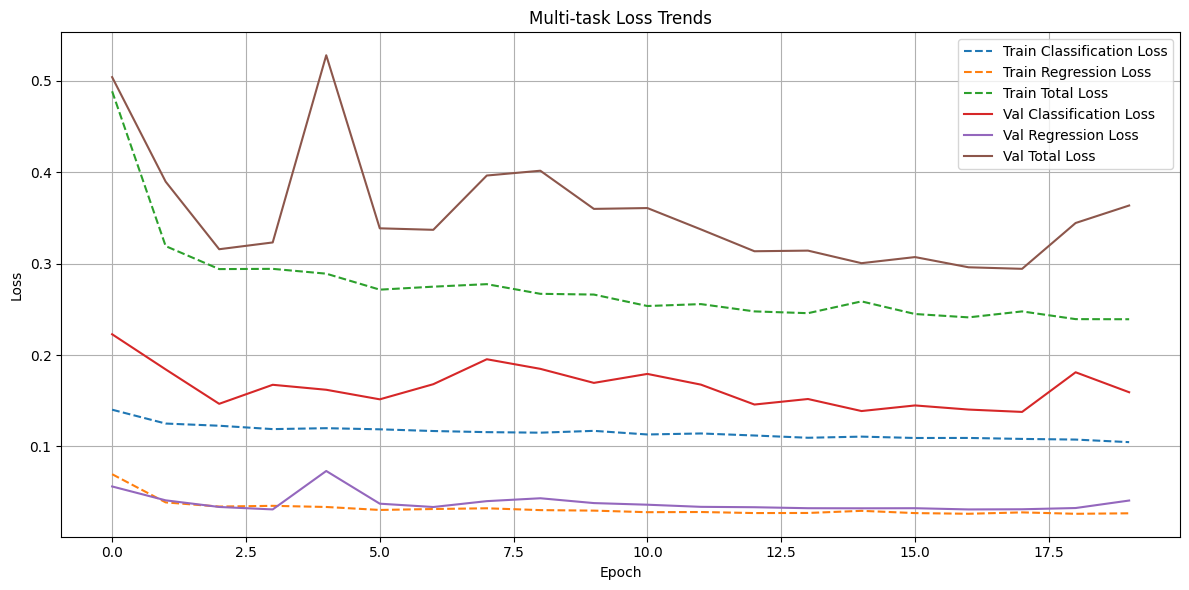

In [12]:
import json
import matplotlib.pyplot as plt

# JSON 불러오기
load_path = '/content/drive/MyDrive/cv_project/01unimodal/loss_history_multitask_model2_reg5_1e-3.json'

with open(load_path, 'r') as f:
    loss_history = json.load(f)

# 리스트로 추출
train_cls_losses = loss_history['train_cls_loss']
train_reg_losses = loss_history['train_reg_loss']
train_total_losses = loss_history['train_total_loss']
val_cls_losses = loss_history['val_cls_loss']
val_reg_losses = loss_history['val_reg_loss']
val_total_losses = loss_history['val_total_loss']

# 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_cls_losses, label='Train Classification Loss', linestyle='--')
plt.plot(train_reg_losses, label='Train Regression Loss', linestyle='--')
plt.plot(train_total_losses, label='Train Total Loss', linestyle='--')

plt.plot(val_cls_losses, label='Val Classification Loss')
plt.plot(val_reg_losses, label='Val Regression Loss')
plt.plot(val_total_losses, label='Val Total Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multi-task Loss Trends')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### [11] 예측 수행

In [13]:
from tqdm import tqdm
import json
import torch

# 모델 로드
model = SiameseEfficientNetV2MultiTask().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/cv_project/01unimodal/best_multitask_model2_reg5_1e-3.pth'))
model.eval()

# 예측 수행
results = []

with torch.no_grad():
    for left, right, labels, thicknesses in tqdm(test_loader, desc="Predicting"):
        left, right = left.to(device), right.to(device)

        # 분류 + 회귀 예측
        outputs_cls, outputs_reg = model(left, right)
        probs = torch.softmax(outputs_cls, dim=1)
        preds = torch.argmax(probs, dim=1)
        thickness_preds = outputs_reg.squeeze().cpu()

        for true, pred, prob, true_thick, pred_thick in zip(
            labels.cpu(), preds.cpu(), probs[:, 1].cpu(), thicknesses.cpu(), thickness_preds):

            results.append({
                "true_label": int(true.item()),
                "pred_label": int(pred.item()),
                "prob_thickened": float(prob.item()),  # thickened 클래스 확률
                "true_thickness": float(true_thick.item()),
                "pred_thickness": float(pred_thick.item())
            })

# 결과 저장
output_path = "/content/drive/MyDrive/cv_project/01unimodal/predict_result_multitask_model2_reg5_1e-3.json"
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"예측 결과 저장 완료: {output_path}")

Predicting: 100%|██████████| 7/7 [01:44<00:00, 14.93s/it]

예측 결과 저장 완료: /content/drive/MyDrive/cv_project/01unimodal/predict_result_multitask_model2_reg5_1e-3.json


### [12] 평가

[Classification Evaluation]
정확도 (Accuracy): 0.7300
AUC-ROC: 0.8320

분류 리포트:
              precision    recall  f1-score   support

      Normal       0.77      0.66      0.71        50
   Thickened       0.70      0.80      0.75        50

    accuracy                           0.73       100
   macro avg       0.73      0.73      0.73       100
weighted avg       0.73      0.73      0.73       100

Confusion Matrix:
[[33 17]
 [10 40]]


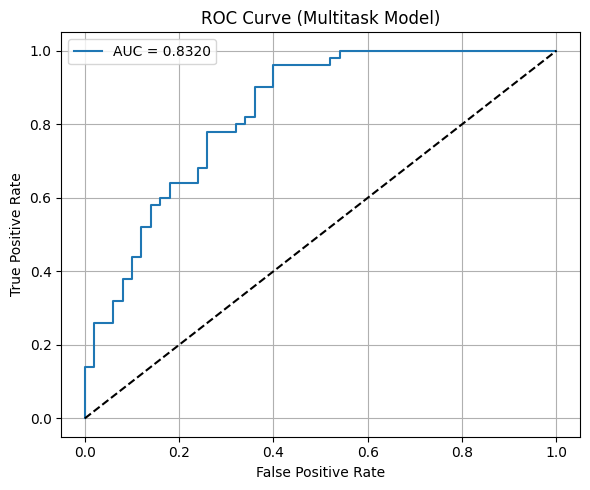


[Regression Evaluation]
RMSE: 0.1646
MAE:  0.1282
R²:   0.2635


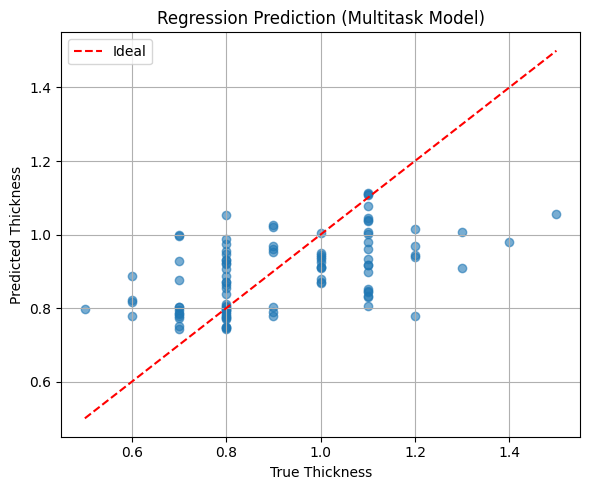

In [15]:
import json
import numpy as np
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)
import matplotlib.pyplot as plt

# 예측 결과 불러오기
with open("/content/drive/MyDrive/cv_project/01unimodal/predict_result_multitask_model2_reg5_1e-3.json", "r") as f:
    results = json.load(f)

# 분류 관련 데이터
y_true = [r["true_label"] for r in results]
y_pred = [r["pred_label"] for r in results]
y_prob = [r["prob_thickened"] for r in results]

# 회귀 관련 데이터
y_true_reg = [r["true_thickness"] for r in results]
y_pred_reg = [r["pred_thickness"] for r in results]

# === 분류 평가 === #
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)
accuracy = np.mean(np.array(y_true) == np.array(y_pred))

print("[Classification Evaluation]")
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")
print("\n분류 리포트:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Thickened"]))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# === ROC Curve === #
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multitask Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 회귀 평가 === #
mse = mean_squared_error(y_true_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_reg, y_pred_reg)
r2 = r2_score(y_true_reg, y_pred_reg)

print("\n[Regression Evaluation]")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# === 회귀 산점도 === #
plt.figure(figsize=(6, 5))
plt.scatter(y_true_reg, y_pred_reg, alpha=0.6)
plt.plot([min(y_true_reg), max(y_true_reg)], [min(y_true_reg), max(y_true_reg)], 'r--', label="Ideal")
plt.xlabel("True Thickness")
plt.ylabel("Predicted Thickness")
plt.title("Regression Prediction (Multitask Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
